In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import json
from collections import Counter
import pickle
import numpy as np

from efficientnet_pytorch import EfficientNet

import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.metrics.functional import accuracy

import albumentations as A
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2

from sklearn import metrics, model_selection
from sklearn.model_selection import StratifiedKFold

import optuna
from optuna.integration import PyTorchLightningPruningCallback
os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torchsnooper as sn

# Look at data

In [4]:
main_path = "/media/hdd/Datasets/leafDisease/"

In [5]:
df = pd.read_csv(main_path+'train.csv')

In [6]:
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [8]:
df["kfold"]=-1
df=df.sample(frac=1).reset_index(drop=True)
stratify=StratifiedKFold(n_splits=5)
for i,(t_idx,v_idx) in enumerate(stratify.split(X=df.image_id.values,y=df.label.values)):
    df.loc[v_idx,"kfold"]=i
    df.to_csv("train_folds.csv",index=False)

In [9]:
with open(main_path+'label_num_to_disease_map.json','r') as f:
    name_mapping = json.load(f)
name_mapping = {int(k):v for k,v in name_mapping.items()}
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

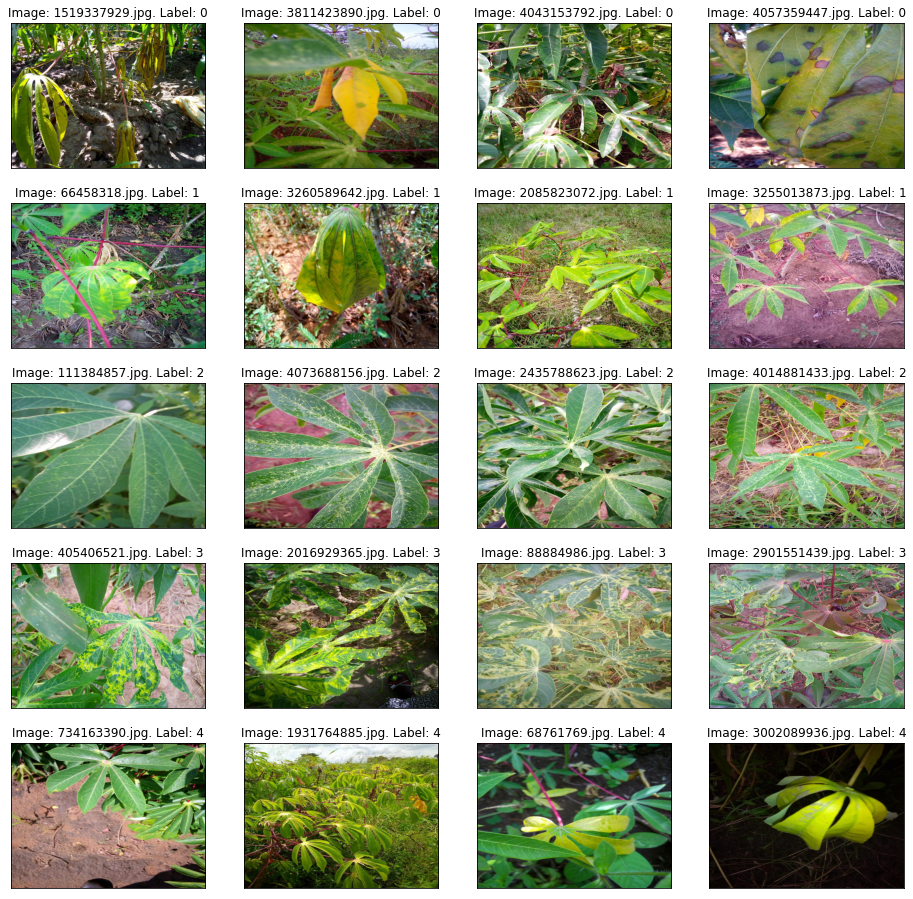

In [10]:
selected_images = []
fig = plt.figure(figsize=(16, 16))
for class_id, class_name in name_mapping.items():
    for i, (idx, row) in enumerate(df.loc[df['label'] == class_id].sample(4).iterrows()):
        ax = fig.add_subplot(5, 4, class_id * 4 + i + 1, xticks=[], yticks=[])
        img = cv2.imread(f"{main_path}train_images/{row['image_id']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(f"Image: {row['image_id']}. Label: {row['label']}")
        if i == 0:
            selected_images.append(img)

# Create model

In [11]:
# Efficient net b5      
class LitModel(pl.LightningModule):
    def __init__(self, trial,num_classes, learning_rate=1e-4,weight_decay=0.0001):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.num_classes = num_classes  
        self.trial = trial
        
#         self.learning_rate = learning_rate
#         self.weight_decay = weight_decay
        
        self.learning_rate = self.trial.suggest_float("learning_rate",1e-4,1e-2)
        self.weight_decay = self.trial.suggest_float("weight_decay",1e-4,1e-2)
        
        self.enet = EfficientNet.from_pretrained('efficientnet-b5', num_classes= self.num_classes)
        in_features=self.enet._fc.in_features
        self.enet._fc=nn.Linear(in_features,num_classes)
        
#     @sn.snoop()
    def forward(self, x):
        out = self.enet(x)
        return out
    
    def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        optimizer_name = self.trial.suggest_categorical("optimizer", ["Adam","RMSprop","SGD"])
        optimizer = getattr(optim, optimizer_name)(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        return (
            [optimizer],
            [scheduler]
        )

#     @sn.snoop()
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch["x"] , train_batch["y"]
        preds = self(x)
        loss = F.cross_entropy(preds, y)
#         loss.requires_grad = True 
        acc = accuracy(preds, y)
        self.log('train_acc_step', acc)
        self.log('train_loss', loss)
        return loss
    

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch["x"] , val_batch["y"]
        preds = self(x)
        loss = F.cross_entropy(preds, y)
#         loss.requires_grad = True 
        acc = accuracy(preds, y)
        self.log('val_acc_step', acc)
        self.log('val_loss', loss)
        

In [12]:
class ImageClassDs(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        self.transforms=transforms
        
    def __getitem__(self,index):
        im_path=os.path.join(self.imfolder,self.df.iloc[index]['image_id'])
        x=cv2.imread(im_path,cv2.IMREAD_COLOR)
        x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
        
        if(self.transforms):
            x=self.transforms(image=x)['image']
        
        if(self.train):
            y=self.df.iloc[index]['label']
            return {
                    "x":x,
                    "y":y,
                }    
        else:
            return {"x":x}
        
    def __len__(self):
        return len(self.df)

# Load data

In [13]:
class ImDataModule(pl.LightningDataModule):
    def __init__(self,trial,df, batch_size, num_classes, data_dir: str = "/media/hdd/Datasets/leafDisease/train_images/", img_size=(256,256)):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = A.Compose([
                        A.RandomResizedCrop(img_size,img_size, p=1.0),
                        A.Transpose(p=0.5),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ShiftScaleRotate(p=0.5),
                        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                        A.CoarseDropout(p=0.5),
                        A.Cutout(p=0.5),
                        ToTensorV2(p=1.0),
                        ], p=1.)

        self.valid_transform = A.Compose([
                         A.CenterCrop(img_size,img_size, p=1.),
                         A.Resize(img_size, img_size),
                         A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                         ToTensorV2(p=1.0),
                         ], p=1.)

    def setup(self,stage=None):
        dfx=pd.read_csv("./train_folds.csv")
        train=dfx.loc[dfx["kfold"]!=1]
        val=dfx.loc[dfx["kfold"]==1]

        self.train_dataset=ImageClassDs(
                            train,
                            self.data_dir,
                            train=True,
                            transforms=self.train_transform)

        self.valid_dataset=ImageClassDs(
                            val,
                            self.data_dir,
                            train=True,
                            transforms=self.valid_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          num_workers=4,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset,
                          batch_size=self.batch_size,
                          num_workers=4)

In [14]:
batch_size=64
num_classes=5
img_size = 128
DIR = os.getcwd()
MODEL_DIR = os.path.join(DIR, "result")

# Logs

In [16]:
logger = CSVLogger("logs", name="eff-b5")

In [17]:
def objective(trial):

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, "trial_{}".format(trial.number)), monitor="accuracy"
    )
 
    trainer = pl.Trainer(auto_select_gpus=True, gpus=1,
                     precision=16, profiler=False,max_epochs=1,
                    callbacks = [pl.callbacks.ProgressBar(),PyTorchLightningPruningCallback(trial, monitor="val_acc")],
                     automatic_optimization=True,enable_pl_optimizer=True,
                     logger=logger,
                     accelerator='ddp',
                    plugins='ddp_sharded')
 
    model = LitModel(trial,num_classes=num_classes)
    dm = ImDataModule(trial,df,batch_size=batch_size,num_classes=num_classes, img_size=img_size)
    trainer.fit(model, dm)
 
    return trainer.callback_metrics["val_acc_step"].item()

In [18]:
pruner = optuna.pruners.MedianPruner()

In [19]:
study = optuna.create_study(direction="maximize", pruner=pruner)

[I 2021-02-13 19:15:57,382] A new study created in memory with name: no-name-71e314c6-b129-43ca-a739-1abfda2e04d5


In [20]:
study.optimize(objective, n_trials=4, timeout=600)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1

  | Name | Type         | Params
--------------------------------------
0 | enet | EfficientNet | 28.4 M
--------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params


Loaded pretrained weights for efficientnet-b5


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-02-13 19:17:41,198] Trial 0 finished with value: 0.5752336382865906 and parameters: {'learning_rate': 0.006527039648140239, 'weight_decay': 0.005153122882840637, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5752336382865906.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using environment variable NODE_RANK for node rank (0).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name | Type         | Params
--------------------------------------
0 | enet | EfficientNet | 28.4 M
--------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params


Loaded pretrained weights for efficientnet-b5


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-02-13 19:19:17,579] Trial 1 finished with value: 0.5509345531463623 and parameters: {'learning_rate': 0.002882579478451001, 'weight_decay': 0.0020677689248397484, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5752336382865906.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using environment variable NODE_RANK for node rank (0).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name | Type         | Params
--------------------------------------
0 | enet | EfficientNet | 28.4 M
--------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params


Loaded pretrained weights for efficientnet-b5


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2021-02-13 19:20:55,016] Trial 2 finished with value: 0.5434579253196716 and parameters: {'learning_rate': 0.0031860447289306167, 'weight_decay': 0.002532978244601031, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5752336382865906.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using environment variable NODE_RANK for node rank (0).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name | Type         | Params
--------------------------------------
0 | enet | EfficientNet | 28.4 M
--------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params


Loaded pretrained weights for efficientnet-b5


Validation sanity check: 0it [00:00, ?it/s]

[W 2021-02-13 19:21:34,511] Trial 3 failed because of the following error: RuntimeError('DataLoader worker (pid(s) 194469) exited unexpectedly')
Traceback (most recent call last):
  File "/home/eragon/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 872, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/eragon/.local/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.9/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.9/multiprocessing/resource_sharer.py", line 86, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 513, in Client
    answer_challen

RuntimeError: DataLoader worker (pid(s) 194469) exited unexpectedly

In [21]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 4
Best trial:
  Value: 0.5752336382865906
  Params: 
    learning_rate: 0.006527039648140239
    weight_decay: 0.005153122882840637
    optimizer: SGD
